In [3]:
# --------------------------CODE BY MANDI DISHA--------------------------
import psycopg2
import pandas as pd
from psycopg2 import OperationalError

def connect_db():
    """Connect to the PostgreSQL database and return the connection and cursor."""
    try:
        conn = psycopg2.connect(
            host="localhost",
            database="postgres",  # Connected to the 'postgres' database
            user="postgres",
            port="5432",
            password="mandi"
        )
        print("Connection successful!")
        return conn, conn.cursor()
    except OperationalError as e:
        print(f"Connection failed: {e}")
        return None, None

def fetch_movie_data(cur):
    """Run the SQL query and return the results as a Pandas DataFrame."""
    query = """
        SELECT
        r.rating,  -- Grouping by movie rating
        COUNT(s.title) AS movie_count,
        ROUND(AVG(s.production_budget), 2) AS avg_production_budget,  -- Average production budget
        ROUND(AVG(m.userscore), 2) AS avg_userscore,  -- Average user score
        ROUND(AVG(s.worldwide_box_office), 2) AS avg_box_office,  -- Average worldwide box office
        ROUND((AVG(s.worldwide_box_office) - AVG(s.production_budget)) / AVG(s.production_budget) * 100, 2) AS avg_profit_percentage,  -- Profit percentage
        SUM(s.worldwide_box_office) AS total_box_office,  -- Total worldwide box office for each rating
        SUM(s.production_budget) AS total_budget,  -- Total budget for each rating
        ROUND(SUM(s.worldwide_box_office) / SUM(s.production_budget), 2) AS roi_ratio,  -- Return on Investment (ROI)
        
        -- Conditional profit calculation: Only include movies with a budget over $10 million
        ROUND(AVG(
            CASE 
                WHEN s.production_budget > 20000000 THEN (s.worldwide_box_office - s.production_budget) / s.production_budget * 100
                ELSE NULL
            END
        ), 2) AS avg_profit_large_budget_movies

    FROM
        movies m
    INNER JOIN
        sales s ON s.title = m.title
    AND
        s.release_year = EXTRACT(YEAR FROM m.reldate)
    LEFT JOIN 
        rating r ON m.url = r.url
    WHERE
        s.production_budget IS NOT NULL  -- Ensuring we only calculate for movies with known budgets
    AND
        m.userscore IS NOT NULL  -- Ensuring we only calculate for movies with known user scores
    GROUP BY
        r.rating  -- Grouping the results by rating
    ORDER BY
        avg_production_budget DESC,  -- Ordering by the average production budget (descending)
        avg_userscore DESC,  -- Ordering by the average user score (descending)
        avg_box_office DESC; 
    """
    cur.execute(query)
    # Fetch all rows from the query
    rows = cur.fetchall()
    
    # Get column names
    colnames = [desc[0] for desc in cur.description]

    # Return the data as a pandas DataFrame
    return pd.DataFrame(rows, columns=colnames)

def close_db(conn, cur):
    """Close the database connection and cursor."""
    cur.close()
    conn.close()

# Main function to encapsulate everything
def main():
    conn, cur = connect_db()
    if conn and cur:
        movie_data = fetch_movie_data(cur)
        print("Data from the query:")
        print(movie_data.head())  # Display the first few rows

        # Perform some analysis
        # Example: Describe the data
        print("\nSummary statistics:")
        print(movie_data.describe())

        # Example: Sort by average profit percentage
        sorted_data = movie_data.sort_values(by="avg_profit_percentage", ascending=False)
        print("\nTop ratings by profit percentage:")
        print(sorted_data.head())

        # Close the database connection
        close_db(conn, cur)

if __name__ == "__main__":
    main()


#  [END CODE BY MANDI DISHA]





Connection successful!
Data from the query:
    rating  movie_count avg_production_budget avg_userscore avg_box_office  \
0     TV-G            4           91500000.00          7.03   473407170.25   
1        G           48           70885416.67          6.73   245814300.02   
2       PG          428           64224567.76          6.43   201635396.44   
3    PG-13         1122           57289148.87          6.46   171838831.59   
4  Unrated           65           37464924.34          6.48   106835608.08   

  avg_profit_percentage total_box_office total_budget roi_ratio  \
0                417.38       1893628681    366000000      5.17   
1                246.78      11799086401   3402500000      3.47   
2                213.95      86299949677  27488115000      3.14   
3                199.95     192803169045  64278425029      3.00   
4                185.16       6944314525   2435220082      2.85   

  avg_profit_large_budget_movies  
0                         350.00  
1             

In [4]:
#Done by Anastasiya 
#This code connects to a PostgreSQL database, cleans up movie data 
#by removing records with missing values (e.g., for production budget or worldwide box office), 
#and then runs an SQL query to analyze movie performance metrics. 
#The query retrieves the average production budget, metascore, 
#and worldwide box office grouped by the movie's release month. 
#The results are fetched and loaded into a Pandas DataFrame for further analysis,
#including generating summary statistics and sorting movies by production budget. 
#The script then commits any changes and closes the database connection.
import psycopg2
import pandas as pd
from psycopg2 import OperationalError

def connect_db():
    """Connect to the PostgreSQL database and return the connection and cursor."""
    try:
        conn = psycopg2.connect(
            host="localhost",
            database="postgres",  # Connected to the 'postgres' database
            user="postgres",
            port="5432",
            password="Foundation.23"
        )
        print("Connection successful!")
        return conn, conn.cursor()
    except OperationalError as e:
        print(f"Connection failed: {e}")
        return None, None

def fetch_movie_data(cur):
    """Run the SQL query and return the results as a Pandas DataFrame."""
    query = """
    SELECT 
        EXTRACT(MONTH FROM m.reldate) AS release_month,  -- Extracting the month from the release date
        ROUND(AVG(s.production_budget), 2) AS avg_production_budget,  -- Average production budget
        ROUND(AVG(m.metascore), 2) AS avg_metascore,  -- Average metascore
        ROUND(AVG(s.worldwide_box_office), 2) AS avg_box_office  -- Average worldwide box office
    FROM
        sales_v20 s
    INNER JOIN
        movies2 m
    ON
        s.title = m.title
    AND
        s.release_year = EXTRACT(YEAR FROM m.reldate)
    WHERE
        s.production_budget IS NOT NULL  -- Only calculate for movies with known budgets
    AND
        m.metascore IS NOT NULL  -- Only calculate for movies with known metascores
    GROUP BY
        EXTRACT(MONTH FROM m.reldate)  -- Grouping by the month
    ORDER BY
        avg_production_budget DESC,  -- Then by production budget (descending)
        avg_metascore,
        release_month;
    """
    cur.execute(query)
    
    # Fetch all rows from the query
    rows = cur.fetchall()
    
    # Get column names
    colnames = [desc[0] for desc in cur.description]

    # Return the data as a pandas DataFrame
    return pd.DataFrame(rows, columns=colnames)

def clean_data(cur):
    """Delete rows with NULL values in production_budget or worldwide_box_office."""
    delete_query = """
    DELETE FROM sales_v20
    WHERE production_budget IS NULL
    OR worldwide_box_office IS NULL;
    """
    cur.execute(delete_query)


def close_db(conn, cur):
    """Close the database connection and cursor."""
    cur.close()
    conn.close()

# Main function to encapsulate everything
def main():
    conn, cur = connect_db()
    if conn and cur:
        # Clean the data first by removing null/empty values
        clean_data(cur)

        # Fetch the movie data after cleaning
        movie_data = fetch_movie_data(cur)
        print("Data from the query:")
        print(movie_data.head())  # Display the first few rows

        # Perform some analysis
        # Example: Describe the data
        print("\nSummary statistics:")
        print(movie_data.describe())

        # Example: Sort by 'avg_production_budget' (since 'avg_profit_percentage' doesn't exist)
        sorted_data = movie_data.sort_values(by="avg_production_budget", ascending=False)
        print("\nTop movies by production budget:")
        print(sorted_data.head())

        # Commit any changes (in case of DELETE) and close the database connection
        conn.commit()
        close_db(conn, cur)

# Fix the main function entry point
if __name__ == "__main__":
    main()

Connection successful!
Data from the query:
  release_month avg_production_budget avg_metascore avg_box_office
0             5           63597304.48         56.15   205076656.27
1             6           59944112.86         56.54   195103356.17
2             7           55723245.93         55.85   177124325.11
3            11           53939179.75         59.77   160756398.24
4            12           51481538.46         60.52   163654119.23

Summary statistics:
       release_month avg_production_budget avg_metascore avg_box_office
count             12                    12            12             12
unique            12                    12            12             12
top                5           63597304.48         56.15   205076656.27
freq               1                     1             1              1

Top movies by production budget:
  release_month avg_production_budget avg_metascore avg_box_office
0             5           63597304.48         56.15   205076656.27
1    

Connection successful!


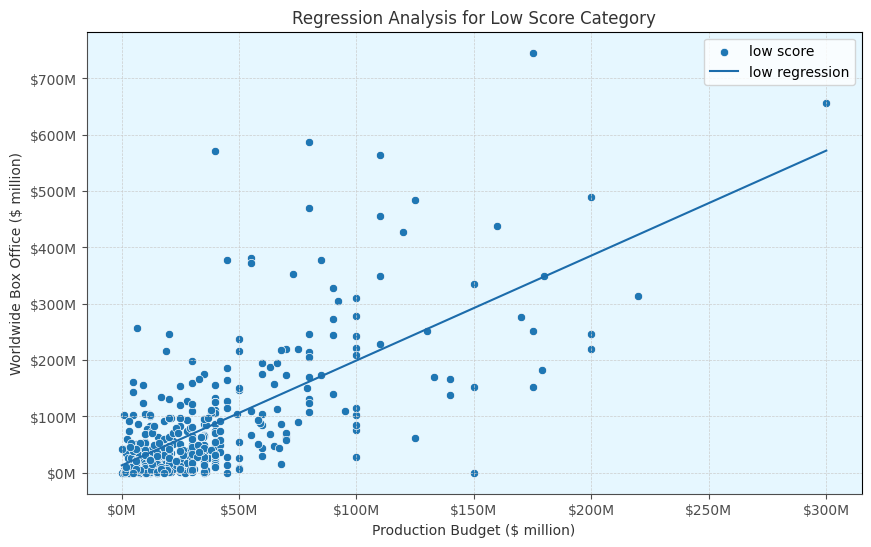


=== Regression Summary for Low Score ===
                             OLS Regression Results                             
Dep. Variable:     worldwide_box_office   R-squared:                       0.475
Model:                              OLS   Adj. R-squared:                  0.473
Method:                   Least Squares   F-statistic:                     352.5
Date:                  Fri, 20 Sep 2024   Prob (F-statistic):           1.75e-56
Time:                          01:04:56   Log-Likelihood:                -7696.1
No. Observations:                   392   AIC:                         1.540e+04
Df Residuals:                       390   BIC:                         1.540e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

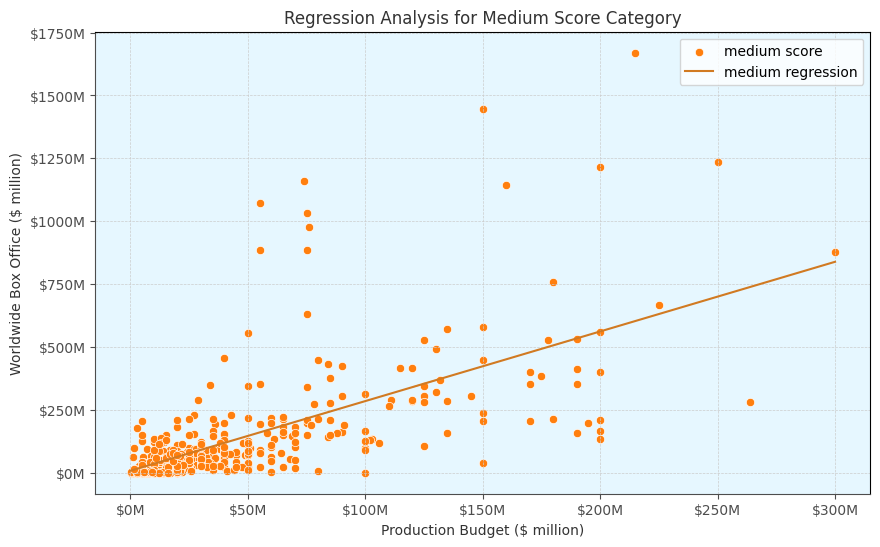


=== Regression Summary for Medium Score ===
                             OLS Regression Results                             
Dep. Variable:     worldwide_box_office   R-squared:                       0.423
Model:                              OLS   Adj. R-squared:                  0.422
Method:                   Least Squares   F-statistic:                     286.9
Date:                  Fri, 20 Sep 2024   Prob (F-statistic):           1.16e-48
Time:                          01:04:57   Log-Likelihood:                -8003.2
No. Observations:                   393   AIC:                         1.601e+04
Df Residuals:                       391   BIC:                         1.602e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

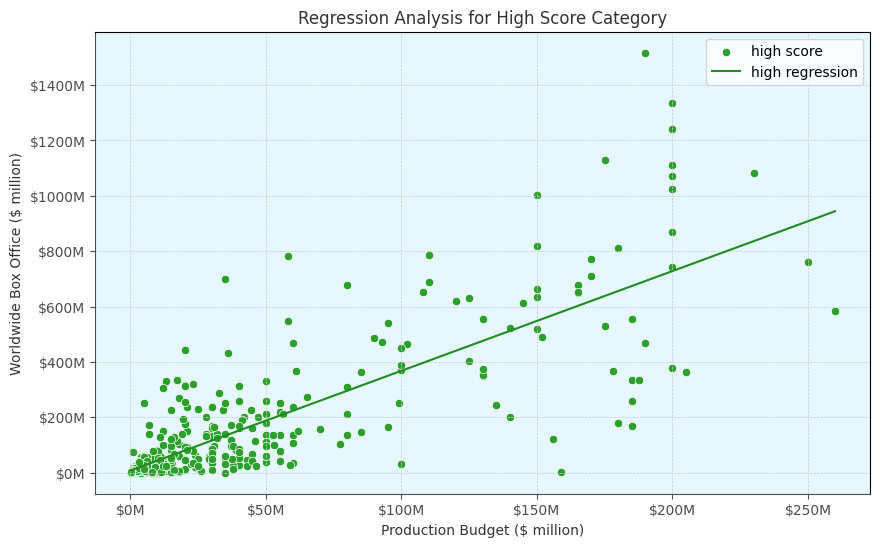


=== Regression Summary for High Score ===
                             OLS Regression Results                             
Dep. Variable:     worldwide_box_office   R-squared:                       0.654
Model:                              OLS   Adj. R-squared:                  0.653
Method:                   Least Squares   F-statistic:                     736.7
Date:                  Fri, 20 Sep 2024   Prob (F-statistic):           7.08e-92
Time:                          01:04:58   Log-Likelihood:                -7919.2
No. Observations:                   392   AIC:                         1.584e+04
Df Residuals:                       390   BIC:                         1.585e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

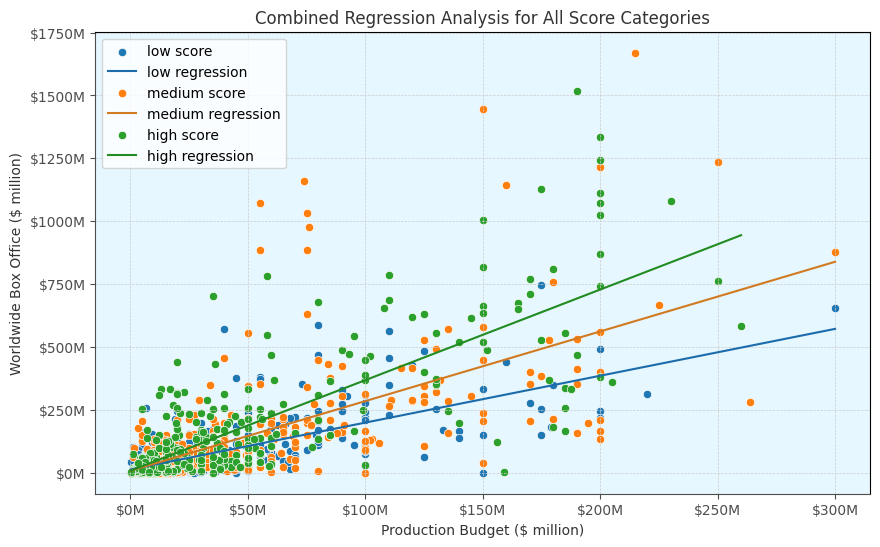

In [1]:
import psycopg2
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
from psycopg2 import OperationalError

try:
    # Connect to the PostgreSQL database
    conn = psycopg2.connect(
        host="localhost",
        database="postgres",  # Connected to the 'postgres' database
        user="postgres",
        password="Tapiac11"
    )
    print("Connection successful!")

    # Create a cursor object to interact with the database
    cur = conn.cursor()

    # SQL query to select data for regression analysis
    query = """
    SELECT title_year, 
           production_budget, 
           worldwide_box_office, 
           avg_idvscore
    FROM expert_sales
    WHERE production_budget IS NOT NULL
      AND worldwide_box_office IS NOT NULL
      AND avg_idvscore IS NOT NULL;
    """

    # Execute the SQL query
    cur.execute(query)

    # Fetch all the rows from the result
    rows = cur.fetchall()

    # Retrieve column names from the query result
    colnames = [desc[0] for desc in cur.description]

    # Load the fetched data into a pandas DataFrame
    df = pd.DataFrame(rows, columns=colnames)

    # Convert columns to numeric types, coercing any errors (such as invalid formats)
    df['production_budget'] = pd.to_numeric(df['production_budget'], errors='coerce')
    df['worldwide_box_office'] = pd.to_numeric(df['worldwide_box_office'], errors='coerce')
    df['avg_idvscore'] = pd.to_numeric(df['avg_idvscore'], errors='coerce')

    # Remove any rows with missing or infinite values
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['production_budget', 'avg_idvscore', 'worldwide_box_office'])

    # Create a categorical variable by dividing avg_idvscore into 3 equal parts (low, medium, high)
    df_clean['score_category'] = pd.qcut(df_clean['avg_idvscore'], 3, labels=["low", "medium", "high"])

    # Define custom colors for scatter plots and regression lines for each score category
    colors = {
        'low': {'scatter': '#1f77b4', 'line': '#1c6cab'},      # Blue shades for low category
        'medium': {'scatter': '#ff7f0e', 'line': '#d17a22'},   # Orange shades for medium category
        'high': {'scatter': '#2ca02c', 'line': '#228b22'}      # Green shades for high category
    }

    # Step 1: Create separate scatter and regression plots for each score category
    for category in ['low', 'medium', 'high']:
        df_category = df_clean[df_clean['score_category'] == category]

        # Define the independent variable (X) and dependent variable (y)
        X = df_category[['production_budget']]
        X = sm.add_constant(X)  # Add a constant (intercept) to the regression model
        y = df_category['worldwide_box_office']

        # Fit the OLS regression model
        model = sm.OLS(y, X).fit()

        # Initialize a new figure for the current category
        plt.figure(figsize=(10, 6))

        # Plot the scatter points for production budget vs worldwide box office
        sns.scatterplot(x='production_budget', y='worldwide_box_office', 
                        data=df_category, label=f'{category} score',
                        color=colors[category]['scatter'])

        # Predict values for the regression line and plot it
        predicted = model.predict(X)
        sns.lineplot(x=df_category['production_budget'], y=predicted, 
                     label=f'{category} regression',
                     color=colors[category]['line'])

        # Customize the background and axis colors
        ax = plt.gca()
        ax.set_facecolor('#e6f7ff')  # Set background color to light blue
        ax.spines['bottom'].set_color('#4d4d4d')  # Customize axis color to dark grey
        ax.spines['left'].set_color('#4d4d4d')
        ax.xaxis.label.set_color('#4d4d4d')  # Set axis label color
        ax.yaxis.label.set_color('#4d4d4d')
        ax.tick_params(axis='x', colors='#4d4d4d')  # Set tick color for x-axis
        ax.tick_params(axis='y', colors='#4d4d4d')  # Set tick color for y-axis

        # Add gridlines for better readability
        ax.grid(True, which='both', color='#cccccc', linestyle='--', linewidth=0.5)

        # Set title and labels with custom colors
        plt.title(f'Regression Analysis for {category.capitalize()} Score Category', color='#333333')
        plt.xlabel('Production Budget ($ million)', color='#333333')
        plt.ylabel('Worldwide Box Office ($ million)', color='#333333')

        # Format x-axis and y-axis ticks to show values in millions
        plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${int(x*1e-6)}M'))
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'${int(y*1e-6)}M'))

        # Show the plot
        plt.legend()
        plt.show()

        # Print the regression summary for the current category
        print(f"\n=== Regression Summary for {category.capitalize()} Score ===")
        print(model.summary())

    # Step 2: Create a combined scatter and regression plot for all categories
    plt.figure(figsize=(10, 6))

    # Iterate through each score category to plot them on the same graph
    for category in ['low', 'medium', 'high']:
        df_category = df_clean[df_clean['score_category'] == category]

        # Prepare independent and dependent variables
        X = df_category[['production_budget']]
        X = sm.add_constant(X)  # Add a constant (intercept)
        y = df_category['worldwide_box_office']

        # Fit the OLS regression model
        model = sm.OLS(y, X).fit()

        # Plot the scatter points and regression line for each category
        sns.scatterplot(x='production_budget', y='worldwide_box_office', 
                        data=df_category, label=f'{category} score',
                        color=colors[category]['scatter'])

        predicted = model.predict(X)
        sns.lineplot(x=df_category['production_budget'], y=predicted, 
                     label=f'{category} regression',
                     color=colors[category]['line'])

    # Customize the background and axis colors for the combined graph
    ax = plt.gca()
    ax.set_facecolor('#e6f7ff')
    ax.spines['bottom'].set_color('#4d4d4d')
    ax.spines['left'].set_color('#4d4d4d')
    ax.xaxis.label.set_color('#4d4d4d')
    ax.yaxis.label.set_color('#4d4d4d')
    ax.tick_params(axis='x', colors='#4d4d4d')
    ax.tick_params(axis='y', colors='#4d4d4d')

    # Add gridlines and customize plot title/labels
    ax.grid(True, which='both', color='#cccccc', linestyle='--', linewidth=0.5)
    plt.title('Combined Regression Analysis for All Score Categories', color='#333333')
    plt.xlabel('Production Budget ($ million)', color='#333333')
    plt.ylabel('Worldwide Box Office ($ million)', color='#333333')

    # Format x-axis and y-axis ticks to show values in millions
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${int(x*1e-6)}M'))
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'${int(y*1e-6)}M'))

    # Show the combined plot
    plt.legend()
    plt.show()

    # Close the cursor and connection after completing the analysis
    cur.close()
    conn.close()

# Handle any potential errors during database connection or data processing
except OperationalError as e:
    print(f"The error '{e}' occurred")
except ValueError as ve:
    print(f"Data processing error: {ve}")
